In [1]:
#importing the modules and changing directory

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob

os.getcwd()
os.chdir("/home/aniket/Documents/datasets/fog parkinsons/dataset_fog_release/")

In [2]:
#creating a list of datasets where each element corresponds to a patient

allFiles = glob.glob(os.getcwd() + "/*.txt")
df = []
s = "Time of sample,Ankle_1,Ankle_2,Ankle_3,Thigh_1,Thigh_2,Thigh_3,Trunk_1,Trunk_2,Trunk_3,status"

for filename in allFiles:
        df.append(pd.read_csv(filename,sep = "\s+", header = None, names = s.split(",")))

In [3]:
# ignoring status = 0 as it's not part of the experiment

for i in range(len(df)):
    df[i] = df[i][df[i].status != 0]

In [5]:
# l = []
# for i in range(17):
#     l.append(df[i].shape)
# l
# s = 0b
# for i in l:
#     s = s + i[0]
# s

1140835

In [4]:
#selecting only status "1" and "2", "no FOG" and "FOG"

df_1 = []
df_2 = []

for i in range(17):
    df_1.append(df[i][df[i].status == 1])
    df_2.append(df[i][df[i].status == 2])


In [5]:
#drop "status" columns in df_1 and df_2

for i in range(len(df_1)):
    df_1[i].drop(["status"], axis = 1, inplace = True)
    df_2[i].drop(["status"], axis = 1, inplace = True)


/home/aniket/.local/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


##### WE can proceed to explore the data and see the relationships between the different features

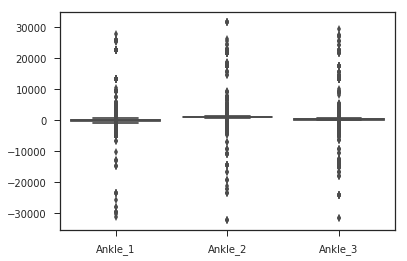

In [201]:
import seaborn as sns
sns.set(style="ticks", color_codes=True)

sns.boxplot(data=df_1[["Ankle_1", "Ankle_2", "Ankle_3"]])
# sns.boxplot(x=df[0]["Ankle_1"])
# df_normal[["Ankle_1", "Ankle_2", "Ankle_3"]].describe()

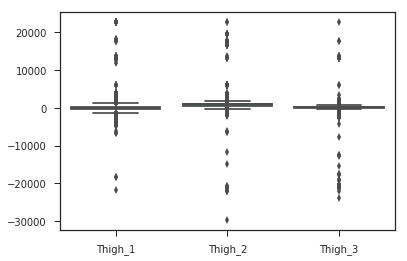

In [185]:
sns.boxplot(data=df_1[["Thigh_1", "Thigh_2", "Thigh_3"]])

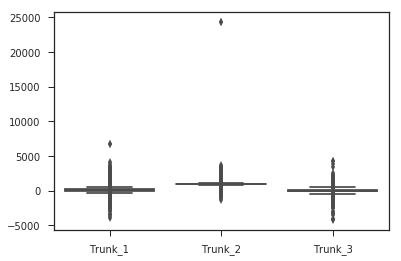

In [186]:
sns.boxplot(data=df_1[["Trunk_1", "Trunk_2", "Trunk_3"]])

We see that for "Non-FOG" events the data for ankles, thigh and trunk is very wide

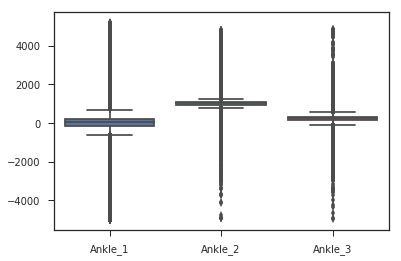

In [187]:
sns.boxplot(data=df_2[["Ankle_1", "Ankle_2", "Ankle_3"]])

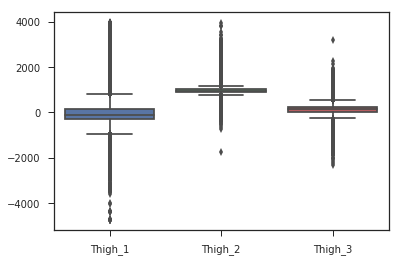

In [188]:
sns.boxplot(data=df_2[["Thigh_1", "Thigh_2", "Thigh_3"]])

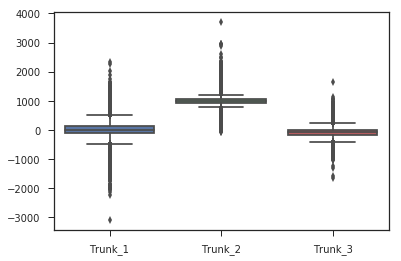

In [189]:
sns.boxplot(data=df_2[["Trunk_1", "Trunk_2", "Trunk_3"]])

##### We can explore
the correlation between the different variables

In [204]:
df_normal.corr()

,Time of sample,Ankle_1,Ankle_2,Ankle_3,Thigh_1,Thigh_2,Thigh_3,Trunk_1,Trunk_2,Trunk_3,status,Ankle,Thigh,Trunk
Time of sample,1.000000,-0.099294,-0.062389,-0.031591,0.053845,-0.304672,-0.045569,-0.045076,-0.262843,-0.011670,NaN,-0.121819,-0.134088,-0.175623
Ankle_1,-0.099294,1.000000,0.039519,-0.055649,-0.219606,0.060443,0.109254,-0.027327,0.068703,0.013727,NaN,0.773940,-0.101327,0.031119
Ankle_2,-0.062389,0.039519,1.000000,-0.075682,-0.018855,0.179117,-0.117413,-0.074045,0.061264,-0.131806,NaN,0.487021,0.033434,-0.086326
Ankle_3,-0.031591,-0.055649,-0.075682,1.000000,-0.012299,-0.103762,0.102153,0.071074,-0.040086,0.142971,NaN,0.360056,-0.024720,0.103073
Thigh_1,0.053845,-0.219606,-0.018855,-0.012299,1.000000,0.025257,-0.120790,0.156113,-0.029004,0.117088,NaN,-0.185744,0.763911,0.139684
Thigh_2,-0.304672,0.060443,0.179117,-0.103762,0.025257,1.000000,-0.012395,-0.140123,0.423303,-0.328985,NaN,0.089077,0.538697,-0.042974
Thigh_3,-0.045569,0.109254,-0.117413,0.102153,-0.120790,-0.012395,1.000000,0.046133,0.023700,0.222862,NaN,0.072633,0.282791,0.172798
Trunk_1,-0.045076,-0.027327,-0.074045,0.071074,0.156113,-0.140123,0.046133,1.000000,-0.078030,0.230121,NaN,-0.026235,0.068920,0.639485
Trunk_2,-0.262843,0.068703,0.061264,-0.040086,-0.029004,0.423303,0.023700,-0.078030,1.000000,-0.099173,NaN,0.065863,0.207545,0.445837
Trunk_3,-0.011670,0.013727,-0.131806,0.142971,0.117088,-0.328985,0.222862,0.230121,-0.099173,1.000000,NaN,0.009140,0.007110,0.675256


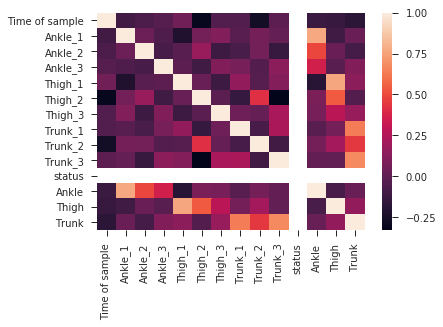

In [205]:
import seaborn as sns
corr = df_normal.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

By examining the above correlation matrix, we can approximate the readings of "Ankle_1", "Ankle_2" and "Ankle_3" into a combined "Ankle" and repeat the same for "Thigh" and "Trunk"

In [6]:
#aggregate values of ankle_1, ankle_2 and ankle_3 into a single averaged value ankle, same for thigh, trunk

# def aggFeatures(df, feature1, feature2, feature3):
#     a = range(1,3)
#     s1 = [feature1 + "_" + str(i) for i in range(1,4)]
#     s2 = [feature2 + "_" + str(i) for i in range(1,4)]
#     s3 = [feature3 + "_" + str(i) for i in range(1,4)]
        
#     for i in range(len(df)):
#             df[i][feature1] = abs(df[i][s1[0]]) + abs(df[i][s1[1]]) + abs(df[i][s1[2]])
#             df[i][feature2] = abs(df[i][s2[0]]) + abs(df[i][s2[1]]) + abs(df[i][s2[2]])
#             df[i][feature3] = abs(df[i][s3[0]]) + abs(df[i][s3[1]]) + abs(df[i][s3[2]])
def aggFeatures(df, feature1, feature2, feature3):
    a = range(1,3)
    s1 = [feature1 + "_" + str(i) for i in range(1,4)]
    s2 = [feature2 + "_" + str(i) for i in range(1,4)]
    s3 = [feature3 + "_" + str(i) for i in range(1,4)]
        
    for i in range(len(df)):
            df[i][feature1] = (df[i][s1[0]]) + (df[i][s1[1]]) + (df[i][s1[2]])
            df[i][feature2] = (df[i][s2[0]]) + (df[i][s2[1]]) + (df[i][s2[2]])
            df[i][feature3] = (df[i][s3[0]]) + (df[i][s3[1]]) + (df[i][s3[2]])
                        

In [7]:
# apply the transformation and view data

aggFeatures(df, "Ankle", "Thigh", "Trunk")
df[0].head()

,Time of sample,Ankle_1,Ankle_2,Ankle_3,Thigh_1,Thigh_2,Thigh_3,Trunk_1,Trunk_2,Trunk_3,status,Ankle,Thigh,Trunk
15999,250000,-161,1029,99,-190,981,171,58,1028,116,1,967,962,1202
16000,250015,-131,1019,89,-136,972,151,38,1000,106,1,977,987,1144
16001,250031,-121,1019,99,-100,981,111,9,990,155,1,997,992,1154
16002,250046,-111,1029,69,-81,981,90,29,1000,126,1,987,990,1155
16003,250062,-101,1019,59,-81,981,90,0,990,155,1,977,990,1145


In [9]:
# check if the columns were actually removed

df_2[0].columns

Index(['Time of sample', 'Ankle_1', 'Ankle_2', 'Ankle_3', 'Thigh_1', 'Thigh_2',
       'Thigh_3', 'Trunk_1', 'Trunk_2', 'Trunk_3', 'Ankle', 'Thigh', 'Trunk'],
      dtype='object')

## We will make recurrence plots for each attribute (ankle_1...etc) for each file

In [10]:
#checking the (rows, columns) of each instance of "1/Non-FOG" and "2/FOG"

for i in range(17):
    print(df_1[i].shape)

(27254, 13)
(99110, 13)
(52905, 13)
(27464, 13)
(19842, 13)
(22064, 13)
(94078, 13)
(56889, 13)
(142722, 13)
(36425, 13)
(50491, 13)
(70365, 13)
(74848, 13)
(21121, 13)
(14335, 13)
(132482, 13)
(87655, 13)


### (Issue) Recurrence plots is crashing for large data
We can eliminate this by taking a window of values (ex: mean of 8 or 16 values at once and consider that single value instead of all 8/16)

In [11]:
# defining a function to calculate average of values over a window 

def avgData(data, limit, window):
    data = np.array([sum(data.iloc[i:i+window])/window for i in range(0,limit, window)])
    return data

In [55]:
# defining a function to calculate recurrence plots for a particular data

from pyts.image import RecurrencePlots

# Recurrence plot transformation
rp = RecurrencePlots(dimension=1,
                     epsilon='percentage_points',
                     percentage=30)

def RP(data, limit = 0, window = 0, avg = False):
    if avg == True:
        data = avgData(data, limit, window)
        X_rp = rp.fit_transform(data.reshape(1,-1))
        plt.figure(figsize=(8, 8))
        plt.imshow(X_rp[0], cmap='binary', origin='lower')
        
    else:
        X_rp = rp.fit_transform(data.values.reshape(1,-1))
        # X_rp = rp.fit_transform(X)

        # Show the results for the first time series
        plt.figure(figsize=(8, 8))
        plt.imshow(X_rp[0], cmap='binary', origin='lower')
    return plt.show()

In [36]:
df_1[15].shape

(132482, 13)

#### Bottom 3 are RP's of Ankle_1, Ankle_2, Ankle_3 for Non-FOG 

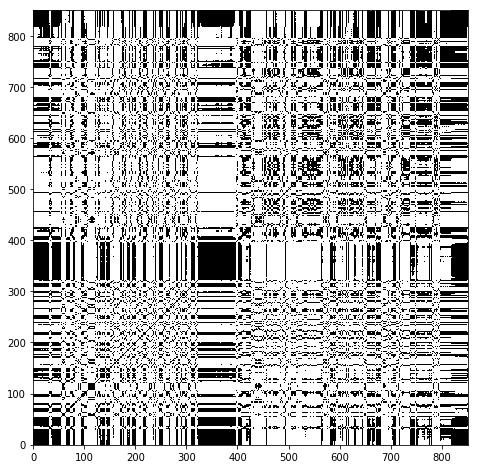

In [35]:
RP(df_1[0]["Ankle_1"], limit = 27254, window = 32, avg = True)

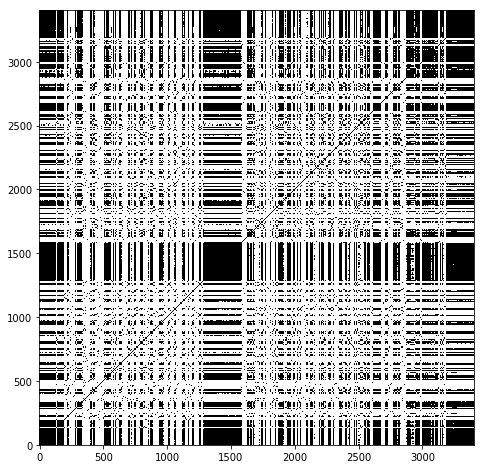

In [26]:
RP(df_1[0]["Ankle_2"], limit = 27256, window = 8, avg = True)

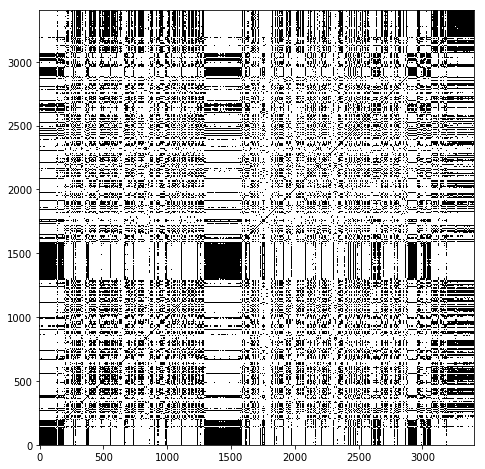

In [12]:
RP(df_1[0]["Ankle_3"], limit = 27256, window = 8, avg = True)

#### Bottom 3 are the RPs for Ankle_1, Ankle_2 and Ankle_3 for "FOG" events 

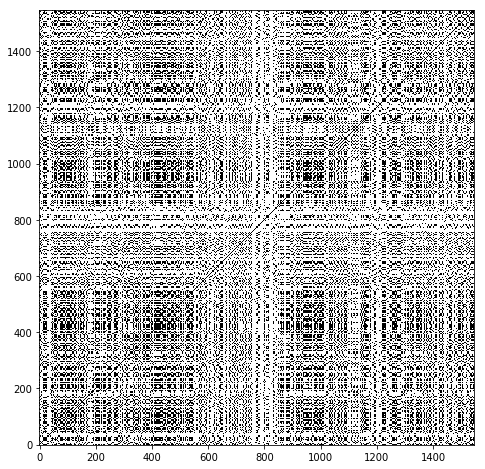

In [56]:
RP(df_2[0]["Thigh_1"], limit = df_1[1].shape[0], window = 32, avg = False)

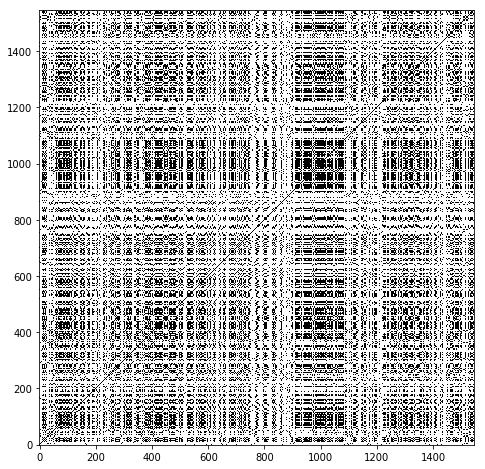

In [19]:
RP(df_2[0]["Ankle_2"], limit = 1547, window = 1, avg = False)

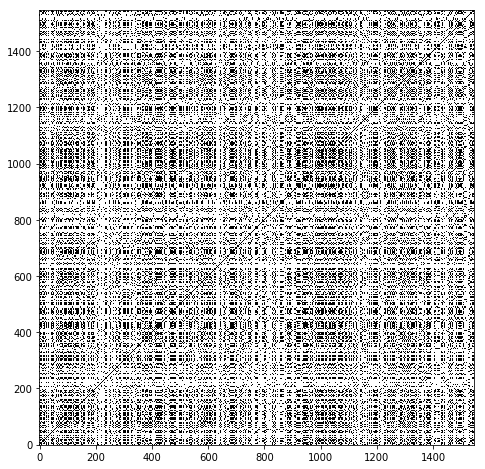

In [20]:
RP(df_2[2]["Ankle_3"], limit = 1547, window = 1, avg = False)

### Observations 
From the above observations we can see that recurrence patterns in "Non-FOG' events are more clearly defined than their "FOG" counterparts

In [32]:
# saving images in a seperate diretory called "rps"

# os.getcwd()
# os.mkdir("/home/aniket/Documents/datasets/fog parkinsons/dataset_fog_release/rps")
os.chdir("/home/aniket/Documents/datasets/fog parkinsons/dataset_fog_release/rps")

In [58]:
#defining function to save RP as images in the above-mentioned directory

def RPsave(data, limit = 0, window = 0, avg = False, nonFOG = True, label = None):
    if avg == True and nonFOG == True:
        data = avgData(data, limit, window)
        X_rp = rp.fit_transform(data.reshape(1,-1))
#         plt.figure(figsize=(8, 8))
#         plt.imshow(X_rp[0], cmap='gray', origin='lower')
        
    else:
        X_rp = rp.fit_transform(data.values.reshape(1,-1))
        # X_rp = rp.fit_transform(X)

        # Show the results for the first time series
#         plt.figure(figsize=(8, 8))
#         plt.imshow(X_rp[0], cmap='gray', origin='lower')
    return plt.imsave(label + ".png", X_rp[0])

In [76]:
#checking if the function is working

os.getcwd()
path = "/home/aniket/Documents/datasets/fog parkinsons/dataset_fog_release/rps"
os.chdir(path)

# RPsave(df_2[0]["Ankle_3"], limit = 1547, window = 1, avg = False)


In [82]:
df_1[4].shape

(19842, 13)

In [81]:
# # # making "non-FOG" RPs for all features in df_1

for df_index in range(3,4):
    for column_index in range(1,df_1[df_index].shape[1]):
        RPsave(df_1[df_index].iloc[:, column_index], limit = df_1[df_index].shape[0], window = 16, avg = True, label = str(df_index) + "_" + str(column_index))

In [29]:
for i in range(17):
    print(df_2[i].shape)

(1547, 13)
(8413, 13)
(13017, 13)
(1337, 13)
(0, 13)
(3537, 13)
(17287, 13)
(8072, 13)
(0, 13)
(12859, 13)
(17353, 13)
(3876, 13)
(16034, 13)
(0, 13)
(2306, 13)
(0, 13)
(5147, 13)


In [74]:
# creating Rp's for FOG events

path = "/home/aniket/Documents/datasets/fog parkinsons/dataset_fog_release/rps_fog"
# os.mkdir(path)
os.chdir(path)

for df_index in range(16,17):
    for column_index in range(1,df_2[df_index].shape[1]):
        RPsave(df_1[df_index].iloc[:, column_index], limit = df_2[df_index].shape[0], window = 2, avg = True, label = str(df_index) + "_" + str(column_index))

### Exploring the saved images and performing appropriate preprocessing before running the CNN

In [116]:
import cv2
# os.getcwd()
img = cv2.imread("1_4.png")
img2= cv2.imread("0_3.png")

print(img.shape)

(3098, 3098, 3)


In [8]:
import os
import glob
import cv2

os.chdir("/home/aniket/Documents/datasets/fog parkinsons/dataset_fog_release/rps_fog")
# os.getcwd()
allFiles = glob.glob(os.getcwd() + "/*.png")
x = []
for file in allFiles:
    img = str(file.split("/")[-1])
    x.append(cv2.imread(img).shape[0])
    
import seaborn as sns
sns.boxplot(x)

804

/home/aniket/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/aniket/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6510: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


(<matplotlib.axes._subplots.AxesSubplot at 0x7fd043f637b8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd043f637b8>)

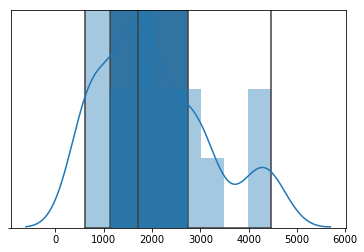

In [6]:
os.chdir("/home/aniket/Documents/datasets/fog parkinsons/dataset_fog_release/rps")
# os.getcwd()
allFiles = glob.glob(os.getcwd() + "/*.png")
x, y, z = [], [], []
for file in allFiles:
    img = str(file.split("/")[-1])
    x.append(cv2.imread(img).shape[0])
    
import seaborn as sns
sns.boxplot(x)

#### We shall see the distribution of our image sizes

Plotted only one dimension as they are square shaped, which makes one dimension equal to another

/home/aniket/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6510: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


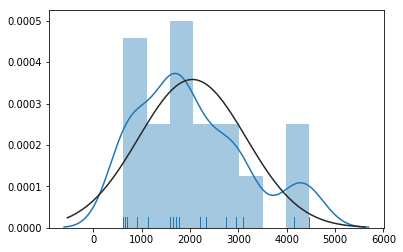

In [122]:
from scipy.stats import norm
sns.distplot(x, fit = norm, rug = True)

## Deep learning architecture using keras

In [1]:
from random import shuffle 
from tqdm import tqdm 
import cv2
import numpy as np
import os


IMG_SIZE = 600
LR = 1e-3
fog_path = "/home/aniket/Documents/datasets/fog parkinsons/dataset_fog_release/rps_fog"
non_fog_path = "/home/aniket/Documents/datasets/fog parkinsons/dataset_fog_release/rps"
MODEL_NAME = 'RP-{}-{}.model'.format(LR, 'conv') 


def create_data(): 
    # Creating an empty list where we should the store the training data 
    # after a little preprocessing of the data 
    data = [] 
  
    # tqdm is only used for interactive loading 
    # loading the training data 
    for img in tqdm(os.listdir(non_fog_path)): 
   
  
        path = os.path.join(non_fog_path, img) 
  
        # loading the image from the path and then converting them into 
        # greyscale for easier covnet prob 
        img = cv2.imread(path) 
  
        # resizing the image for processing them in the covnet 
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE)) 
  
        # final step-forming the training data list with numpy array of the images 
        data.append([np.array(img).reshape(IMG_SIZE, IMG_SIZE, 3), np.array([1, 0])]) 
        
        
    for img in tqdm(os.listdir(fog_path)): 
   
  
        path = os.path.join(fog_path, img) 
  
        # loading the image from the path and then converting them into 
        # greyscale for easier covnet prob 
        img = cv2.imread(path) 
  
        # resizing the image for processing them in the covnet 
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE)) 
  
        # final step-forming the training data list with numpy array of the images 
        data.append([np.array(img).reshape(IMG_SIZE, IMG_SIZE, 3), np.array([1, 0])])
  
    # shuffling of the training data to preserve the random state of our data 
    shuffle(data)
        
    np.save('data_1.npy', data) 
    

In [2]:
os.chdir("/home/aniket/Documents/datasets/fog parkinsons/dataset_fog_release")
create_data()

100%|██████████| 155/155 [00:10<00:00, 14.47it/s]


In [1]:
import tensorflow as tf
writer = tf.summary.FileWriter("/home/aniket/Documents/datasets/fog parkinsons/dataset_fog_release/log", tf.get_default_graph())

/home/aniket/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from sklearn.model_selection import StratifiedKFold
import numpy as np
import os
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import math

os.chdir("/home/aniket/Documents/datasets/fog parkinsons/dataset_fog_release/")

data = np.load("data_1.npy")


import sklearn
from sklearn.model_selection import train_test_split


IMG_SIZE = 600
X = np.array([i[0] for i in data])
Y = np.array([i[1] for i in data])
Y_1 = np.array([i[1][0] for i in data])


limit = math.ceil(355/2)
X_train, X_test, y_train, y_test = X[:limit], X[limit:], Y[:limit], Y[limit:]

limit2 = math.ceil(0.6*limit) 
X_train_1, X_validate, y_train_1, y_validate = X_train[:limit2], X_train[limit2:], y_train[:limit2], y_train[limit2:]
# X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, Y, test_size=0.33, random_state=2)
# X_train = X_train.reshape(X_train.shape[0], 300, 300 , 3).astype('float32')
# X_test = X_test.reshape(X_test.shape[0], 300, 300 , 3).astype('float32')

def create_model():
    model = Sequential()

	model.add(Conv2D(5, (3, 3), input_shape=(600,600,3)))
	model.add(Activation("relu"))
	model.add(MaxPooling2D(pool_size=(2, 2)))

	model.add(Conv2D(5, (3, 3)))
	model.add(Activation("relu"))
	model.add(MaxPooling2D(pool_size=(2, 2)))

	model.add(Flatten())
	model.add(Dense(16))
	model.add(Activation("relu"))
	model.add(Dropout(0.5))
	model.add(Dense(2))
	model.add(Activation("sigmoid"))

	model.compile(optimizer='adam',
	              loss='binary_crossentropy',
	              metrics=['accuracy'])
	return model

def train_evaluate(model, X_train, y_train, X_test, y_test):

	model.fit(x = X_train_1,y =  y_train_1,
	          batch_size=12,
	          epochs=5,
	          verbose=2,
	          
	          )
	score = model.evaluate(X_test, y_test, verbose=2)
	print('Test loss:', score[0])
	print('Test accuracy:', score[1])
	acc_list.append(score[1])

if __name__ == "__main__":
    n_folds = 5
    data, labels = X, Y
    skf = StratifiedKFold(n_splits=5)
    acc_list = []
    for train, test in skf.split(X, Y_1):
        model = None # Clearing the NN.
        model = create_model()
        train_evaluate(model, data[train], labels[train], data[test], labels[test])
    model.save("model.h5")
    print(acc_list)
    print(sum(acc_list)/len(acc_list))

In [67]:
# model.fit(x = X_train, y = y_train, verbose = 2, validation_data = (X_test, y_test))